In [12]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

In [3]:
# print Read distribution per sample in 'filtered' as 'just_want_to_see_depth.pdf'

see_read_depth_sample <- function(vcf){
    names(vcf)
    pdf(file="just_want_to_see_depth.pdf",height=6,width=20)
    a<-ggplot(vcf, aes(x=ID, y=log10(REF_COUNT+ALT_COUNT)))+
    geom_violin()+
    geom_hline(yintercept=3,linetype=2,col="blue")+
    theme_bw()+
    theme(axis.text.x=element_text(face="bold",size=8,angle=90))
    print(a)
    dev.off()
    }

#------------------------------------------------------------------------------------
      
filtering_error_prone_variants<- function(data) {
    filtered <- data[ data$REPEAT_MASKER==0 
               & data$SEGDUP==FALSE 
               & data$HOMOPOLYMER==FALSE 
               & data$DINUCLEOTIDE==FALSE 
               & data$NEAR_INDEL==FALSE 
               & data$UCSC_RPMSK=='pass',]
    return(filtered)
    }

#------------------------------------------------------------------------------------

Calculating_cuttoff_het <- function(vcf, WGS_variants_path){
    WGS_var<-read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_het_var <- subset(WGS_var, Category == "Het")
    print(paste("number of rows of potential het: ", nrow(WGS_het_var)))
    # overlaping variants between WGS potential variants and vcf data
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_het_var$CHROM.POS.REF.ALT)
    print(paste("number of rows of overlapping het between WGS potential variants and vcf data: ",nrow(overlap)))

    # Generate histogram for the MAF upper and lower CI of potential het variants 
    pdf(file="potential_het_var_MAF_hist.pdf",height=6,width=20)
    par(mfrow=c(1,3),mar=c(3, 3, 1, 1))
    hist(overlap$MAF, breaks = 50, xlim=c(0,1))

    hist(overlap$LOWER_CI, breaks = 50, xlim=c(0,1))
    abline(v=quantile(overlap$LOWER_CI, 0.975, na.rm=TRUE), col="red")
    abline(v=quantile(overlap$LOWER_CI, 0.025, na.rm=TRUE), col="red")

    hist(overlap$UPPER_CI, breaks = 50, xlim=c(0,1))
    abline(v=quantile(overlap$UPPER_CI, 0.975, na.rm=TRUE), col="red")
    abline(v=quantile(overlap$UPPER_CI, 0.025, na.rm=TRUE), col="red")
    dev.off()
    
    # upper and lower limit of definition of the het variant
    print(quantile(overlap$LOWER_CI, 0.975, na.rm=TRUE))
    print(quantile(overlap$LOWER_CI, 0.025, na.rm=TRUE))
    print(quantile(overlap$UPPER_CI, 0.975, na.rm=TRUE))
    print(quantile(overlap$UPPER_CI, 0.025, na.rm=TRUE))
    }

#------------------------------------------------------------------------------------

Calculating_cuttoff_homo <- function(vcf, WGS_variants_path){
    WGS_var<-read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_homo_var <- subset(WGS_var, Category == "Alt_Homo")
    print(paste("number of rows of potential homo: ", nrow(WGS_homo_var)))

    # overlaping variants between WGS potential variants and vcf data
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_homo_var$CHROM.POS.REF.ALT)
    head(overlap)
    print(paste("number of rows of overlapping homo between WGS potential variants and vcf data: ",nrow(overlap)))

    # Generate histogram for the MAF upper and lower CI of potential homo variants 
    pdf(file="potential_homo_var_MAF_hist.pdf",height=6,width=7)
    hist(1-overlap$LOWER_CI, breaks = 50, xlim=c(0,0.1))
    abline(v=quantile(1-overlap$LOWER_CI, 0.95, na.rm=TRUE), col="red")
    dev.off()
    
    # lower limit of AF to define 'mosaic variant
    print(quantile(1-overlap$LOWER_CI, 0.95, na.rm=TRUE))
    }

#------------------------------------------------------------------------------------

refine_mosaic_variant_by_cutoff <- function(vcf, WGS_variants_path, Mosaic_LOWER, Mosaic_UPPER){
    WGS_var <- read.table(file=WGS_variants_path, header=T, row.names=NULL)
    #load potential heterozygous variants
    WGS_mosaic_var <- subset(WGS_var, Category %in% c( "Shared_Mosaic", "Unique_Mosaic"))
    overlap <- subset(vcf, vcf$CHROM.POS.REF.ALT %in% WGS_mosaic_var$CHROM.POS.REF.ALT)
    overlap<-subset(overlap, (overlap$LOWER_CI>Mosaic_LOWER & overlap$UPPER_CI<Mosaic_UPPER & overlap$NORMAL_LOWER_CI<Mosaic_LOWER))
    head(overlap)
    print(paste("number of rows: ",nrow(overlap)))
    print(paste("number of variants: ", length(unique(overlap$CHROM.POS.REF.ALT))))
    pdf(file="potential_mosaic_var_MAF_hist.pdf",height=6,width=10)
    hist(overlap$LOWER_CI, breaks = 100, xlim=c(Mosaic_LOWER,Mosaic_UPPER))
    dev.off()
    return(overlap)
    }


# Remove samples that have low depth

In [3]:
# Load final_summary.vcf as 'raw'
raw<-read.table(file="/projects/ps-gleesonlab8/Uniformly_processed_data/20221223_Changuk_Ampliseq_7669_Interneuron_IGM/2_Annotation/final_summary.vcf",header=T)
see_read_depth_sample(raw)    
filtered<-subset(raw, !(raw$ID %in% c("7669_L_sec1_Put_MSN","7669_L_sec1_Put_nonMSN","7669_L_sec2_Put_MSN","7669_L_sec2_Put_nonMSN",
                          "7669_R_P_10_TBR1","7669_R_sec1_Put_MSN","7669_R_sec1_Put_nonMSN","7669_R_sec3_Put_MSN","7669_R_sec3_Put_nonMSN")))
length(unique(filtered$ID)) #156 minus 9
filtered$CHROM.POS.REF.ALT <- NA
filtered$Mosaic <- NA
filtered$CHROM.POS.REF.ALT <- paste(filtered$CHROM,"-",filtered$POS,"-",filtered$REF,"-",filtered$ALT, sep="")
filtered <- relocate(filtered, CHROM.POS.REF.ALT, .after = ALT)
write.table(filtered,"./final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

Warning message:
“Removed 77599 rows containing non-finite values (`stat_ydensity()`).”


png 
  2

[1] 147

# Set cut off of AF

In [4]:
#filtered<-read.table(file="./final_summary_anno3.txt",header=T)
filtered<-read.table(file="./final_summary_anno3.txt",header=T)

In [5]:
#remove JGG for cutoff calculation
filtered_noJGG<-subset(filtered, !(filtered$ID %in% c("JGG")))
nrow(filtered_noJGG)

[1] 351276

In [6]:
Calculating_cuttoff_het
(filtering_error_prone_variants(filtered_noJGG), "../WGS_Variants_7669.txt")

[1] "number of rows of potential het:  152"
[1] "number of rows of overlapping het between WGS potential variants and vcf data:  8030"
    97.5% 
0.5147682 
     2.5% 
0.4562841 
    97.5% 
0.5361286 
     2.5% 
0.4779163 


In [7]:
Calculating_cuttoff_homo(filtering_error_prone_variants(filtered_noJGG), "../WGS_Variants_7669.txt")

[1] "number of rows of potential homo:  59"
[1] "number of rows of overlapping homo between WGS potential variants and vcf data:  3650"
        95% 
0.002360687 


# refine mosaic variant by cutoff

In [8]:
# Load final_summary.txt
filtered<-read.table(file="./final_summary_anno3.txt",header=T)
#filtered_bulk<-filtered[grepl("_Bulk",filtered$ID),]
MV_by_cutoff<-refine_mosaic_variant_by_cutoff(filtered, "../WGS_Variants_7669.txt",0.002360687,0.4562841)

[1] "number of rows:  13234"
[1] "number of variants:  898"


In [9]:
filtered[filtered$CHROM.POS.REF.ALT %in% MV_by_cutoff$CHROM.POS.REF.ALT,]$Mosaic<-1
filtered[!(filtered$CHROM.POS.REF.ALT %in% MV_by_cutoff$CHROM.POS.REF.ALT),]$Mosaic<-0

In [10]:
# names(filtered)
# raw2<-filtered[filtered$Mosaic==1,]
# bks=c(0,0.00236,0.005,0.1,0.20,0.3,0.4,0.456,0.5,0.6,1)
# pdf(file="Interneuron_7669_2022_12_30_Plot.pdf",width=16,height=9)
# for(i in 1:804){
# temp<-raw2[raw2$CHROM.POS.REF.ALT==names(table(raw2$CHROM.POS.REF.ALT))[i],]
# plot <-
# ggplot(temp,aes(x=ID,y=sqrt(MAF),ymin=sqrt(LOWER_CI),ymax=sqrt(UPPER_CI)))+
# 	geom_point(alpha=0.5)+
# 	geom_pointrange()+
# 	geom_hline(yintercept=sqrt(0.00236),linetype=2,col="black")+
#   	geom_hline(yintercept=sqrt(0.456),linetype=2,col="black")+

# 	geom_hline(yintercept=sqrt(0.005),linetype=2,col="grey")+
# 	geom_hline(yintercept=sqrt(0.6),linetype=2,col="grey")+
# 	geom_hline(yintercept=sqrt(0.5),linetype=2,col="grey")+
# 	geom_hline(yintercept=sqrt(0.4),linetype=2,col="grey")+
# 	geom_hline(yintercept=sqrt(1),linetype=2,col="grey")+
# 	geom_hline(yintercept=sqrt(0),linetype=2,col="grey")+
# 	scale_y_continuous(breaks=sqrt(bks),labels=bks)+
# 	scale_color_manual(values = c("pink","#2A3280","#A73326","#666666","#CCCCCC"))+
# 	theme_classic()+
# 	labs(title=names(table(raw2$CHROM.POS.REF.ALT))[i],x="")+
# 	theme(axis.line=element_blank(),axis.text.x=element_text(face="bold",size=5,angle=90,vjust = 0.5))+
# 	geom_segment(aes(x = 0, y = 0, xend = 0, yend = 1),color="black")
# print(plot)
# }
# dev.off()

In [10]:
nrow(filtered[filtered$Mosaic==1,])
names(filtered[filtered$Mosaic==1,])

nrow(MV_by_cutoff)

[1] 132006

[1] "ID"                   "CHROM"                "POS"                 
 [4] "REF"                  "ALT"                  "CHROM.POS.REF.ALT"   
 [7] "ANNO"                 "GENE"                 "GNOMAD_FREQ"         
[10] "REPEAT_MASKER"        "SEGDUP"               "HOMOPOLYMER"         
[13] "REF_SEQ"              "DINUCLEOTIDE"         "NEAR_INDEL"          
[16] "UCSC_RPMSK"           "REF_COUNT"            "ALT_COUNT"           
[19] "MAF"                  "LOWER_CI"             "UPPER_CI"            
[22] "CI_IS_GREATER"        "NORMAL_REF_COUNT"     "NORMAL_ALT_COUNT"    
[25] "NORMAL_MAF"           "NORMAL_LOWER_CI"      "NORMAL_UPPER_CI"     
[28] "NORMAL_CI_IS_GREATER" "Mosaic"

[1] 13234

In [11]:
write.table(filtered,"./final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

# Add Ampliseq_ID to WGS variant call list

In [14]:
# want to know if the variants are called in both WGS and ampliseq within the same tissue
filtered<-read.table(file="./final_summary_anno3.txt",header=T) # JGG included, 9 low quality sample excluded already
WGS_calls <-read.table(file="/projects/ps-gleesonlab8/User/chchung/Interneuron/7669_WGS_raw_calls/7669_300x_WGS_mosaic_candidates_MF_DM_M2_S2_MH.vcf",header=T) # WGS raw variant calls

In [15]:
unique(WGS_calls$ID)

[1] "7669-Br-L-Ins-1"    "7669-skin-R"        "7669-skin-L"       
 [4] "7669-Br-R-Cb-2"     "7669-Br-L-POA"      "7669-Br-R-antTh"   
 [7] "7669-H-RV10"        "7669-H-LA10"        "7669-Br-L-2-antPut"
[10] "7669-Br-L-2-midGp"  "7669-Br-L-Cb-2"     "7669-Br-L-P-1"     
[13] "7669-Br-R-antCau"   "7669-Br-R-F-1"      "7669-Br-R-Ins-1"   
[16] "7669-Br-R-P-1"      "7669-Br-R-T-1"      "7669-H-AO1"        
[19] "7669-H-LV15"        "7669-liver-2"       "7669-Br-R-midPut"  
[22] "7669-Br-L-F-1"      "7669-Br-R-POA"      "7669-Br-L-O-1"     
[25] "7669-Br-L-1-antCau" "7669-Br-L-T-1"      "7669-H-RA9"        
[28] "7669-kidney-R"      "7669-Br-L-antTh"    "7669-kidney-L"     
[31] "7669-Br-R-midGp"    "7669-Br-R-O-1"

In [16]:
WGS_calls$Ampliseq_ID <- NA
WGS_calls[WGS_calls$ID == "7669-Br-L-Ins-1",]$Ampliseq_ID <- '7669_L_Ins_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-skin-R",]$Ampliseq_ID <- '7669_R_Skin_Bulk'
WGS_calls[WGS_calls$ID == "7669-skin-L",]$Ampliseq_ID <- '7669_L_Skin_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-Cb-2",]$Ampliseq_ID <- '7669_R_Cb_2_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-POA",]$Ampliseq_ID <- '7669_L_POA_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-antTh",]$Ampliseq_ID <- '7669_R_sec2_Thal_Bulk' # or 7669_R_sec2_Thal_Bulk 7669_R_2_Thal_Bulk
WGS_calls[WGS_calls$ID == "7669-H-RV10",]$Ampliseq_ID <- '7669_RV10_Bulk'
WGS_calls[WGS_calls$ID == "7669-H-LA10",]$Ampliseq_ID <- '7669_LA10_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-2-antPut",]$Ampliseq_ID <- '7669_L_sec2_Put_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-2-midGp",]$Ampliseq_ID <- '7669_L_sec2_GP_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-Cb-2",]$Ampliseq_ID <- '7669_L_Cb2_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-P-1",]$Ampliseq_ID <- '7669_L_P_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-antCau",]$Ampliseq_ID <- '7669_R_sec1_Cau_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-F-1",]$Ampliseq_ID <- '7669_R_F_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-Ins-1",]$Ampliseq_ID <- '7669_R_Ins_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-P-1",]$Ampliseq_ID <- '7669_R_P_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-T-1",]$Ampliseq_ID <- '7669_R_T_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-H-AO1",]$Ampliseq_ID <- '7669_AO_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-H-LV15",]$Ampliseq_ID <- '7669_LV15_Bulk'
WGS_calls[WGS_calls$ID == "7669-liver-2",]$Ampliseq_ID <- '7669_Liver_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-midPut",]$Ampliseq_ID <- '7669_R_sec2_Put_Bulk' # or 7669_R_2_Put2_bulk
WGS_calls[WGS_calls$ID == "7669-Br-L-F-1",]$Ampliseq_ID <- '7669_L_F_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-POA",]$Ampliseq_ID <- '7669_R_POA_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-O-1",]$Ampliseq_ID <- '7669_L_O_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-1-antCau",]$Ampliseq_ID <- '7669_L_sec1_Cau_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-T-1",]$Ampliseq_ID <- '7669_L_T_1_Bulk'
WGS_calls[WGS_calls$ID == "7669-H-RA9",]$Ampliseq_ID <- '7669_RA9_Bulk'
WGS_calls[WGS_calls$ID == "7669-kidney-R",]$Ampliseq_ID <- '7669_R_kidney_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-L-antTh",]$Ampliseq_ID <- '7669_L_sec2_Thal_Bulk'
WGS_calls[WGS_calls$ID == "7669-kidney-L",]$Ampliseq_ID <- '7669_L_Kidney_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-midGp",]$Ampliseq_ID <- '7669_R_sec2_GP_Bulk'
WGS_calls[WGS_calls$ID == "7669-Br-R-O-1",]$Ampliseq_ID <- '7669_R_O_1_Bulk'

In [17]:
write.table(WGS_calls,"./7669_300x_WGS_mosaic_candidates_MF_DM_M2_S2_MH_AmpliseqID.tsv",sep="\t", row.names=FALSE, col.names=TRUE)

In [18]:
unique(WGS_calls$Ampliseq_ID)

[1] "7669_L_Ins_1_Bulk"     "7669_R_Skin_Bulk"      "7669_L_Skin_Bulk"     
 [4] "7669_R_Cb_2_Bulk"      "7669_L_POA_Bulk"       "7669_R_sec2_Thal_Bulk"
 [7] "7669_RV10_Bulk"        "7669_LA10_Bulk"        "7669_L_sec2_Put_Bulk" 
[10] "7669_L_sec2_GP_Bulk"   "7669_L_Cb2_Bulk"       "7669_L_P_1_Bulk"      
[13] "7669_R_sec1_Cau_Bulk"  "7669_R_F_1_Bulk"       "7669_R_Ins_1_Bulk"    
[16] "7669_R_P_1_Bulk"       "7669_R_T_1_Bulk"       "7669_AO_1_Bulk"       
[19] "7669_LV15_Bulk"        "7669_Liver_Bulk"       "7669_R_sec2_Put_Bulk" 
[22] "7669_L_F_1_Bulk"       "7669_R_POA_Bulk"       "7669_L_O_1_Bulk"      
[25] "7669_L_sec1_Cau_Bulk"  "7669_L_T_1_Bulk"       "7669_RA9_Bulk"        
[28] "7669_R_kidney_Bulk"    "7669_L_sec2_Thal_Bulk" "7669_L_Kidney_Bulk"   
[31] "7669_R_sec2_GP_Bulk"   "7669_R_O_1_Bulk"

# MAF correlation between WGS and Ampliseq

In [4]:
#rm(list = ls())
WGS_calls<-read.table("./7669_300x_WGS_mosaic_candidates_MF_DM_M2_S2_MH_AmpliseqID.tsv",header=T)
filtered<-read.table(file="./final_summary_anno3.txt",header=T) # JGG included, 9 low quality sample excluded already
MV_by_cutoff<-refine_mosaic_variant_by_cutoff(filtered, "../WGS_Variants_7669.txt",0.002360687,0.4562841)

[1] "number of rows:  13234"
[1] "number of variants:  898"


In [5]:
names(MV_by_cutoff)
names(WGS_calls)

[1] "ID"                        "CHROM"                    
 [3] "POS"                       "REF"                      
 [5] "ALT"                       "CHROM.POS.REF.ALT"        
 [7] "ANNO"                      "GENE"                     
 [9] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[11] "SEGDUP"                    "HOMOPOLYMER"              
[13] "REF_SEQ"                   "DINUCLEOTIDE"             
[15] "NEAR_INDEL"                "UCSC_RPMSK"               
[17] "REF_COUNT"                 "ALT_COUNT"                
[19] "MAF"                       "LOWER_CI"                 
[21] "UPPER_CI"                  "CI_IS_GREATER"            
[23] "NORMAL_REF_COUNT"          "NORMAL_ALT_COUNT"         
[25] "NORMAL_MAF"                "NORMAL_LOWER_CI"          
[27] "NORMAL_UPPER_CI"           "NORMAL_CI_IS_GREATER"     
[29] "Mosaic"                    "Mosaic_shared_btw_WGS_Amp"
[31] "Hemisphere"                "Region"                   
[33] "Punch"                     "Cell_Type"                
[35] "Location"                  "AntPost"                  
[37] "DorVen"                    "Organ"                    
[39] "Note"                      "Bulk_main"                
[41] "Sort_main"                 "CTX_BG_HIP_relationship"

[1] "ID"                   "CHROM"                "POS"                 
 [4] "REF"                  "ALT"                  "CHROM.POS.REF.ALT"   
 [7] "Number_Occur"         "ANNO"                 "GENE"                
[10] "GNOMAD_FREQ"          "REPEAT_MASKER"        "SEGDUP"              
[13] "HOMOPOLYMER"          "REF_SEQ"              "DINUCLEOTIDE"        
[16] "NEAR_INDEL"           "UCSC_RPMSK"           "REF_COUNT"           
[19] "ALT_COUNT"            "MAF"                  "LOWER_CI"            
[22] "UPPER_CI"             "CI_IS_GREATER"        "NORMAL_REF_COUNT"    
[25] "NORMAL_ALT_COUNT"     "NORMAL_MAF"           "NORMAL_LOWER_CI"     
[28] "NORMAL_UPPER_CI"      "NORMAL_CI_IS_GREATER" "MosaicForecast"      
[31] "DeepMosaic"           "MuTect2"              "Strelka2"            
[34] "MosaicHunter"         "CODE_M2S2"            "Ampliseq_ID"

In [6]:
#MV_by_cutoff$ID.CHROM.POS.REF.ALT<-NA
MV_by_cutoff$ID.CHROM.POS.REF.ALT <- paste(MV_by_cutoff$ID,MV_by_cutoff$CHROM.POS.REF.ALT, sep="-")
head(MV_by_cutoff)
nrow(MV_by_cutoff)

#WGS_calls$ID.CHROM.POS.REF.ALT<-NA
WGS_calls$ID.CHROM.POS.REF.ALT <- paste(WGS_calls$Ampliseq_ID,WGS_calls$CHROM.POS.REF.ALT, sep="-")
head(WGS_calls)
nrow(WGS_calls)

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,Cell_Type,Location,AntPost,DorVen,Organ,Note,Bulk_main,Sort_main,CTX_BG_HIP_relationship,ID.CHROM.POS.REF.ALT
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
40,7669_AO_1_Bulk,1,47213131,A,G,1-47213131-A-G,intergenic,"EFCAB14(dist=28395),CYP4B1(dist=51539)",0.000e+00,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-47213131-A-G
47,7669_AO_1_Bulk,1,55567901,G,T,1-55567901-G-T,intronic,USP24,0.000e+00,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-55567901-G-T
52,7669_AO_1_Bulk,1,65202139,C,A,1-65202139-C-A,intergenic,"CACHD1(dist=43398),RAVER2(dist=8639)",3.232e-05,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-65202139-C-A
87,7669_AO_1_Bulk,1,103746984,A,T,1-103746984-A-T,intergenic,"COL11A1(dist=172932),LOC101928436(dist=212719)",0.000e+00,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-103746984-A-T
123,7669_AO_1_Bulk,1,159646818,C,T,1-159646818-C-T,intergenic,"APCS(dist=88157),CRP(dist=35261)",3.238e-05,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-159646818-C-T
142,7669_AO_1_Bulk,1,188074317,T,C,1-188074317-T-C,intergenic,"LINC01037(dist=627963),BRINP3(dist=1992480)",3.229e-05,0,⋯,Bulk,NA,NA,NA,HEART,NA,1,0,0,7669_AO_1_Bulk-1-188074317-T-C


[1] 13234

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,Number_Occur,ANNO,GENE,GNOMAD_FREQ,⋯,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,MosaicForecast,DeepMosaic,MuTect2,Strelka2,MosaicHunter,CODE_M2S2,Ampliseq_ID,ID.CHROM.POS.REF.ALT
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
1,7669-Br-L-Ins-1,7,96634136,A,G,7-96634136-A-G,1,ncRNA_intronic,DLX6-AS1,0.0099,⋯,0.594563674,PPPPP_PPPPP,0,0,0,0,1,0,7669_L_Ins_1_Bulk,7669_L_Ins_1_Bulk-7-96634136-A-G
2,7669-Br-L-Ins-1,9,981634,C,T,9-981634-C-T,1,intronic,DMRT3,0.0095,⋯,0.555666663,PPPPP_PPPPP,0,0,0,0,1,0,7669_L_Ins_1_Bulk,7669_L_Ins_1_Bulk-9-981634-C-T
3,7669-skin-R,22,23633111,G,A,22-23633111-G-A,1,intronic,BCR,0.0094,⋯,0.009879242,FFFFF_FFFFF,1,0,1,1,0,2,7669_R_Skin_Bulk,7669_R_Skin_Bulk-22-23633111-G-A
4,7669-Br-L-Ins-1,4,93940762,G,T,4-93940762-G-T,1,intronic,GRID2,0.0091,⋯,0.563637235,PPPPP_PPPPP,0,0,0,0,1,0,7669_L_Ins_1_Bulk,7669_L_Ins_1_Bulk-4-93940762-G-T
5,7669-Br-L-Ins-1,7,17499471,T,C,7-17499471-T-C,1,ncRNA_intronic,KCCAT333,0.0091,⋯,0.525040597,PPPPP_PPPPP,0,0,0,0,1,0,7669_L_Ins_1_Bulk,7669_L_Ins_1_Bulk-7-17499471-T-C
6,7669-Br-L-Ins-1,1,157461275,C,G,1-157461275-C-G,1,intergenic,"ETV3(dist=352892),FCRL5(dist=21892)",0.0090,⋯,0.006800951,FFFFF_FFFFF,0,0,0,0,1,0,7669_L_Ins_1_Bulk,7669_L_Ins_1_Bulk-1-157461275-C-G


[1] 21614

In [7]:
intersect<-WGS_calls[WGS_calls$ID.CHROM.POS.REF.ALT  %in%  MV_by_cutoff$ID.CHROM.POS.REF.ALT,]
intersect2<-MV_by_cutoff[MV_by_cutoff$ID.CHROM.POS.REF.ALT  %in%  WGS_calls$ID.CHROM.POS.REF.ALT,]

In [8]:
intersect <- intersect[order(intersect$ID.CHROM.POS.REF.ALT),]
intersect2 <- intersect2[order(intersect2$ID.CHROM.POS.REF.ALT),]

intersect$Amp_MAF <- intersect2$MAF
intersect$Amp_UPPER_CI <- intersect2$UPPER_CI
intersect$Amp_LOWER_CI <- intersect2$LOWER_CI

In [13]:
p<-ggplot(intersect, aes(x=sqrt(intersect$MAF), y=sqrt(intersect$Amp_MAF)))+
          geom_point(alpha=0.2) + geom_errorbar(alpha=0.5,aes(ymin=sqrt(intersect$Amp_LOWER_CI), ymax=sqrt(intersect$Amp_UPPER_CI)))+
geom_errorbarh(alpha=0.1,aes(xmin =sqrt(intersect$LOWER_CI) ,xmax = sqrt(intersect$UPPER_CI)))+geom_hline(yintercept=sqrt(0.000236),linetype=3,col="blue")+xlim(c(0,sqrt(0.7)))+ylim(c(0,sqrt(0.7)))+geom_abline(intercept=0,slope=1,col="red")+theme_bw()

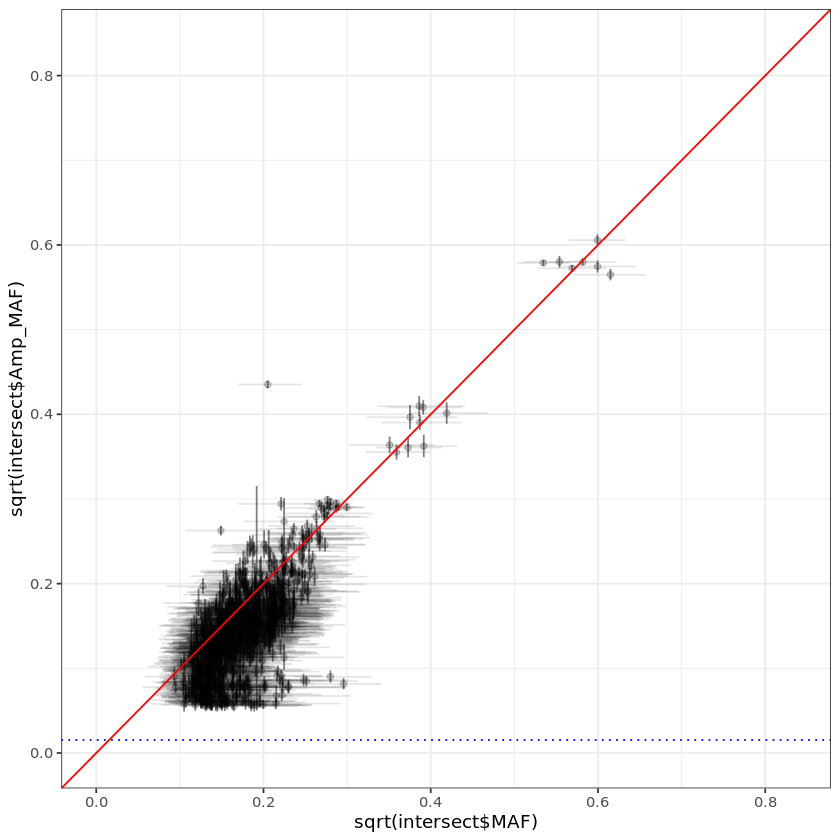

In [14]:
p

In [15]:
pdf(file = "./7669_WGS_TAseq_correlation.pdf",width = 6, height = 6);
p
dev.off()

png 
  2

In [16]:
min(intersect$Amp_LOWER_CI)
nrow(intersect)
length(unique(intersect$POS))

[1] 0.002391982

[1] 1166

[1] 780

In [17]:
cor.test(sqrt(intersect$MAF), sqrt(intersect$Amp_MAF))


	Pearson's product-moment correlation

data:  sqrt(intersect$MAF) and sqrt(intersect$Amp_MAF)
t = 47.76, df = 1164, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7933629 0.8322420
sample estimates:
      cor 
0.8137106 


In [28]:
filtered$Mosaic_shared_btw_WGS_Amp <- NA
filtered[filtered$CHROM.POS.REF.ALT %in% unique(intersect$CHROM.POS.REF.ALT),]$Mosaic_shared_btw_WGS_Amp <- 1
filtered[!(filtered$CHROM.POS.REF.ALT %in% unique(intersect$CHROM.POS.REF.ALT)),]$Mosaic_shared_btw_WGS_Amp <- 0
nrow(filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,])
length(unique(filtered$Mosaic_shared_btw_WGS_Amp))

[1] 114660

[1] 2

# Lolliplot for everything

In [3]:
filtered<-read.table(file="./final_summary_anno3.txt",header=T) # JGG included, 9 low quality sample excluded already

In [5]:
final <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,]
bks=c(0,0.00236,0.005,0.1,0.20,0.3,0.4,0.456,0.5,0.6,1)
pdf(file="Interneuron_7669_2022_12_30_Plot.pdf",width=16,height=9)
for(i in 1:780){
temp<-final[final$CHROM.POS.REF.ALT==names(table(final$CHROM.POS.REF.ALT))[i],]
plot <-
ggplot(temp,aes(x=ID,y=sqrt(MAF),ymin=sqrt(LOWER_CI),ymax=sqrt(UPPER_CI)))+
	geom_point(alpha=0.5)+
	geom_pointrange()+
	geom_hline(yintercept=sqrt(0.00236),linetype=2,col="black")+
  	geom_hline(yintercept=sqrt(0.456),linetype=2,col="black")+

	geom_hline(yintercept=sqrt(0.005),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.6),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.5),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0.4),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(1),linetype=2,col="grey")+
	geom_hline(yintercept=sqrt(0),linetype=2,col="grey")+
	scale_y_continuous(breaks=sqrt(bks),labels=bks)+
	scale_color_manual(values = c("pink","#2A3280","#A73326","#666666","#CCCCCC"))+
	theme_classic()+
	labs(title=paste0("ID05 ",names(table(final$CHROM.POS.REF.ALT))[i],x=""))+
	theme(axis.line=element_blank(),axis.text.x=element_text(face="bold",size=5,angle=90,vjust = 0.5))+
	geom_segment(aes(x = 0, y = 0, xend = 0, yend = 1),color="black")
print(plot)
}
dev.off()

Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message:
“Removed 1 rows containing missing values (`geom_segment()`).”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message:
“Removed 4 rows containing missing values (`geom_segment()`).”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message:
“Removed 2 rows containing missing values (`geom_segment()`).”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message:
“Removed 5 rows containing missing values (`geom_segment()`).”
Warning message in sqrt(LOWER_CI):
“NaNs produced”
Warning message i

png 
  2

In [30]:
head(filtered)
tail(filtered)
print(paste("Total number of rows : ", nrow(filtered),sep=""))
print(paste("Total number of input variant in ampliseq panel : ", length(unique(filtered$CHROM.POS.REF.ALT)),sep=""))
print(paste("Total number of mosaic variants shared between WGS and Ampliseq variant calls in the same tissue : ",
           length(unique(filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,]$CHROM.POS.REF.ALT)),sep=""))

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,7669_AO_1_Bulk,1,1196724,A,T,1-1196724-A-T,intronic,UBE2J2,0.000e+00,0,⋯,0.0006449459,FFFFF_FFFFF,23339,4,1.713576e-04,6.663957e-05,0.0004405579,FFFFF_FFFFF,1,1
2,7669_AO_1_Bulk,1,2878285,C,T,1-2878285-C-T,intergenic,"TTC34(dist=172055),ACTRT2(dist=59761)",3.230e-05,0,⋯,0.0011039810,FFFFF_FFFFF,4725,2,4.231013e-04,1.160373e-04,0.0015414815,FFFFF_FFFFF,0,0
3,7669_AO_1_Bulk,1,3182127,G,A,1-3182127-G-A,intronic,PRDM16,0.000e+00,0,⋯,0.0005095952,FFFFF_FFFFF,32748,10,3.052689e-04,1.658298e-04,0.0005618905,FFFFF_FFFFF,0,0
4,7669_AO_1_Bulk,1,4450513,G,A,1-4450513-G-A,intergenic,"LINC01346(dist=437870),LINC01777(dist=21598)",9.691e-05,0,⋯,0.0010725701,FFFFF_FFFFF,25434,16,6.286837e-04,3.870304e-04,0.0010210658,FFFFF_FFFFF,1,1
5,7669_AO_1_Bulk,1,4465349,T,G,1-4465349-T-G,intergenic,"LINC01346(dist=452706),LINC01777(dist=6762)",0.000e+00,0,⋯,0.0002495680,FFFFF_FFFFF,25915,2,7.716943e-05,2.116289e-05,0.0002813527,FFFFF_FFFFF,1,1
6,7669_AO_1_Bulk,1,5764433,A,G,1-5764433-A-G,intergenic,"MIR4417(dist=140230),MIR4689(dist=158299)",0.000e+00,0,⋯,0.0015980500,FFFFF_FFFFF,2558,2,7.812500e-04,2.142731e-04,0.0028442073,FFFFF_FFFFF,0,0


,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
353677,JGG,X,148488165,A,T,X-148488165-A-T,intergenic,"AFF2(dist=405972),IDS(dist=70356)",0,0,⋯,0.0108758822,PPPPP_PPFPP,7949,69,8.605637e-03,6.806025e-03,0.0108758822,PPPPP_PPFPP,0,0
353678,JGG,X,149459544,G,C,X-149459544-G-C,intergenic,"MIR2114(dist=63226),MAMLD1(dist=72001)",0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0
353679,JGG,X,150945179,C,A,X-150945179-C-A,intergenic,"CNGA2(dist=31143),LOC105373368(dist=127724)",0,0,⋯,0.0012185366,FFFFF_FFFFF,4644,1,2.152853e-04,3.800414e-05,0.0012185366,FFFFF_FFFFF,1,1
353680,JGG,X,151132909,G,A,X-151132909-G-A,intronic,GABRE,0,0,⋯,0.0005342279,FFFFF_FFFFF,10599,1,9.433962e-05,1.665345e-05,0.0005342279,FFFFF_FFFFF,1,1
353681,JGG,X,152981139,C,A,X-152981139-C-A,exonic:nonsynonymous_SNV,"BCAP31:NM_001139457:exon4:c.G400T:p.V134L,BCAP31:NM_005745:exon4:c.G199T:p.V67L,BCAP31:NM_001139441:exon4:c.G199T:p.V67L,BCAP31:NM_001256447:exon4:c.G199T:p.V67L,",0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0
353682,JGG,X,153693881,G,A,X-153693881-G-A,intronic,PLXNA3,0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0


[1] "Total number of rows : 353682"
[1] "Total number of input variant in ampliseq panel : 2406"
[1] "Total number of mosaic variants shared between WGS and Ampliseq variant calls in the same tissue : 780"


In [31]:
write.table(filtered,"./final_summary_anno3.txt",sep="\t", row.names=FALSE, col.names=TRUE)

# swapped sample re-annotation

In [1]:
filtered <- read.table("/projects/ps-gleesonlab8/User/chchung/Interneuron/20221223_7669_Ampliseq_QC/20230101_QC/final_summary_anno3.txt",header=T,sep="\t")

In [32]:
unique(filtered$ID)

[1] "7669_AO_1_Bulk"           "7669_LA10_Bulk"          
  [3] "7669_L_Adrenal_Bulk"      "7669_L_Cb2_Bulk"         
  [5] "7669_L_CC_2_COUPTF2"      "7669_L_CC_2_DLX1"        
  [7] "7669_L_EC_COUPTF2"        "7669_L_EC_DLX1"          
  [9] "7669_L_F_1_Bulk"          "7669_L_F_1_COUPTF2"      
 [11] "7669_L_F_1_DLX1"          "7669_L_F_1_TBR1"         
 [13] "7669_L_I_1_COUPTF2"       "7669_L_I_1_DLX1"         
 [15] "7669_L_I_1_TBR1"          "7669_L_Ins_1_Bulk"       
 [17] "7669_Liver_Bulk"          "7669_L_Kidney_Bulk"      
 [19] "7669_L_mO_COUPTF2"        "7669_L_mO_DLX1"          
 [21] "7669_L_O_1_Bulk"          "7669_L_O_1_COUPTF2"      
 [23] "7669_L_O_1_DLX1"          "7669_L_O_1_TBR1"         
 [25] "7669_L_P_1_Bulk"          "7669_L_P_1_COUPTF2"      
 [27] "7669_L_P_1_DLX1"          "7669_L_P_1_TBR1"         
 [29] "7669_L_POA_Bulk"          "7669_L_POA_DLX1"         
 [31] "7669_L_sec1_Cau_Bulk"     "7669_L_sec1_Cau_DLX1"    
 [33] "7669_L_sec1_Put_DLX1"     "7669_L_sec2_GP_Bulk"     
 [35] "7669_L_sec2_GP_DLX1"      "7669_L_sec2_Put_Bulk"    
 [37] "7669_L_sec2_Thal_Bulk"    "7669_L_sec2_Thal_COUPTF2"
 [39] "7669_L_sec2_Thal_DLX1"    "7669_L_sec3_Hip_COUPTF2" 
 [41] "7669_L_sec3_Hip_DLX1"     "7669_L_Skin_Bulk"        
 [43] "7669_L_T_1_Bulk"          "7669_L_T_1_COUPTF2"      
 [45] "7669_L_T_1_DLX1"          "7669_L_T_1_TBR1"         
 [47] "7669_LV15_Bulk"           "7669_R_2_Put2_Bulk"      
 [49] "7669_R_2_Thal_Bulk"       "7669_RA9_Bulk"           
 [51] "7669_R_Adrenal_Bulk"      "7669_R_Ant_Cau_DLX1"     
 [53] "7669_R_Ant_Put_DLX1"      "7669_R_Cb_2_Bulk"        
 [55] "7669_R_CCMid_COUPTF2"     "7669_R_CCMid_DLX1"       
 [57] "7669_R_CC_Mid_TBR1"       "7669_R_EC_COUPTF2"       
 [59] "7669_R_EC_DLX1"           "7669_R_EC_TBR1"          
 [61] "7669_R_F_1_Bulk"          "7669_R_F_1_COUPTF2"      
 [63] "7669_R_F_1_DLX1"          "7669_R_F_1_NeuN"         
 [65] "7669_R_F_1_TBR1"          "7669_R_I_1_COUPTF2"      
 [67] "7669_R_I_1_DLX1"          "7669_R_I_1_TBR1"         
 [69] "7669_R_Ins_1_Bulk"        "7669_R_kidney_Bulk"      
 [71] "7669_R_mO_COUPTF2"        "7669_R_mO_DLX1"          
 [73] "7669_R_mO_TBR1"           "7669_R_O_10_DLX1"        
 [75] "7669_R_O_11_DLX1"         "7669_R_O_1_Bulk"         
 [77] "7669_R_O_1_COUPTF2"       "7669_R_O_1_DLX1"         
 [79] "7669_R_O_1_NeuN"          "7669_R_O_1_TBR1"         
 [81] "7669_R_O_2_DLX1"          "7669_R_O_3_DLX1"         
 [83] "7669_R_O_4_DLX1"          "7669_R_O_5_DLX1"         
 [85] "7669_R_O_6_DLX1"          "7669_R_O_7_DLX1"         
 [87] "7669_R_O_8_DLX1"          "7669_R_O_9_DLX1"         
 [89] "7669_R_Olf_DLX1"          "7669_R_P_10_DLX1"        
 [91] "7669_R_P_11_DLX1"         "7669_R_P_11_TBR1"        
 [93] "7669_R_P_12_DLX1"         "7669_R_P_12_TBR1"        
 [95] "7669_R_P_13_DLX1"         "7669_R_P_13_TBR1"        
 [97] "7669_R_P_14_DLX1"         "7669_R_P_14_TBR1"        
 [99] "7669_R_P_15_DLX1"         "7669_R_P_15_TBR1"        
[101] "7669_R_P_16_DLX1"         "7669_R_P_16_TBR1"        
[103] "7669_R_P_17_DLX1"         "7669_R_P_17_TBR1"        
[105] "7669_R_P_1_Bulk"          "7669_R_P_1_COUPTF2"      
[107] "7669_R_P_1_DLX1"          "7669_R_P_1_NeuN"         
[109] "7669_R_P_1_TBR1"          "7669_R_P_2_DLX1"         
[111] "7669_R_P_2_TBR1"          "7669_R_P_3_DLX1"         
[113] "7669_R_P_3_TBR1"          "7669_R_P_4_DLX1"         
[115] "7669_R_P_4_TBR1"          "7669_R_P_5_DLX1"         
[117] "7669_R_P_5_TBR1"          "7669_R_P_6_DLX1"         
[119] "7669_R_P_6_TBR1"          "7669_R_P_7_DLX1"         
[121] "7669_R_P_7_TBR1"          "7669_R_P_8_DLX1"         
[123] "7669_R_P_8_TBR1"          "7669_R_P_9_DLX1"         
[125] "7669_R_P_9_DLX"           "7669_R_P_9_TBR1"         
[127] "7669_R_POA_Bulk"          "7669_R_POA_DLX1"         
[129] "7669_R_sec1_Cau_Bulk"     "7669_R_sec2_GP_Bulk"     
[131] "7669_R_sec2_GP_DLX1"      "7669_R_sec2_Put_Bulk"    
[133] "7669_R_sec2_Thal_Bulk"    "7669_R_s

In [33]:
head(filtered)
tail(filtered)
names(filtered)

,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,7669_AO_1_Bulk,1,1196724,A,T,1-1196724-A-T,intronic,UBE2J2,0.000e+00,0,⋯,0.0006449459,FFFFF_FFFFF,23339,4,1.713576e-04,6.663957e-05,0.0004405579,FFFFF_FFFFF,1,1
2,7669_AO_1_Bulk,1,2878285,C,T,1-2878285-C-T,intergenic,"TTC34(dist=172055),ACTRT2(dist=59761)",3.230e-05,0,⋯,0.0011039810,FFFFF_FFFFF,4725,2,4.231013e-04,1.160373e-04,0.0015414815,FFFFF_FFFFF,0,0
3,7669_AO_1_Bulk,1,3182127,G,A,1-3182127-G-A,intronic,PRDM16,0.000e+00,0,⋯,0.0005095952,FFFFF_FFFFF,32748,10,3.052689e-04,1.658298e-04,0.0005618905,FFFFF_FFFFF,0,0
4,7669_AO_1_Bulk,1,4450513,G,A,1-4450513-G-A,intergenic,"LINC01346(dist=437870),LINC01777(dist=21598)",9.691e-05,0,⋯,0.0010725701,FFFFF_FFFFF,25434,16,6.286837e-04,3.870304e-04,0.0010210658,FFFFF_FFFFF,1,1
5,7669_AO_1_Bulk,1,4465349,T,G,1-4465349-T-G,intergenic,"LINC01346(dist=452706),LINC01777(dist=6762)",0.000e+00,0,⋯,0.0002495680,FFFFF_FFFFF,25915,2,7.716943e-05,2.116289e-05,0.0002813527,FFFFF_FFFFF,1,1
6,7669_AO_1_Bulk,1,5764433,A,G,1-5764433-A-G,intergenic,"MIR4417(dist=140230),MIR4689(dist=158299)",0.000e+00,0,⋯,0.0015980500,FFFFF_FFFFF,2558,2,7.812500e-04,2.142731e-04,0.0028442073,FFFFF_FFFFF,0,0


,ID,CHROM,POS,REF,ALT,CHROM.POS.REF.ALT,ANNO,GENE,GNOMAD_FREQ,REPEAT_MASKER,⋯,UPPER_CI,CI_IS_GREATER,NORMAL_REF_COUNT,NORMAL_ALT_COUNT,NORMAL_MAF,NORMAL_LOWER_CI,NORMAL_UPPER_CI,NORMAL_CI_IS_GREATER,Mosaic,Mosaic_shared_btw_WGS_Amp
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
353677,JGG,X,148488165,A,T,X-148488165-A-T,intergenic,"AFF2(dist=405972),IDS(dist=70356)",0,0,⋯,0.0108758822,PPPPP_PPFPP,7949,69,8.605637e-03,6.806025e-03,0.0108758822,PPPPP_PPFPP,0,0
353678,JGG,X,149459544,G,C,X-149459544-G-C,intergenic,"MIR2114(dist=63226),MAMLD1(dist=72001)",0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0
353679,JGG,X,150945179,C,A,X-150945179-C-A,intergenic,"CNGA2(dist=31143),LOC105373368(dist=127724)",0,0,⋯,0.0012185366,FFFFF_FFFFF,4644,1,2.152853e-04,3.800414e-05,0.0012185366,FFFFF_FFFFF,1,1
353680,JGG,X,151132909,G,A,X-151132909-G-A,intronic,GABRE,0,0,⋯,0.0005342279,FFFFF_FFFFF,10599,1,9.433962e-05,1.665345e-05,0.0005342279,FFFFF_FFFFF,1,1
353681,JGG,X,152981139,C,A,X-152981139-C-A,exonic:nonsynonymous_SNV,"BCAP31:NM_001139457:exon4:c.G400T:p.V134L,BCAP31:NM_005745:exon4:c.G199T:p.V67L,BCAP31:NM_001139441:exon4:c.G199T:p.V67L,BCAP31:NM_001256447:exon4:c.G199T:p.V67L,",0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0
353682,JGG,X,153693881,G,A,X-153693881-G-A,intronic,PLXNA3,0,0,⋯,NA,nan,NA,NA,NA,NA,NA,nan,0,0


[1] "ID"                        "CHROM"                    
 [3] "POS"                       "REF"                      
 [5] "ALT"                       "CHROM.POS.REF.ALT"        
 [7] "ANNO"                      "GENE"                     
 [9] "GNOMAD_FREQ"               "REPEAT_MASKER"            
[11] "SEGDUP"                    "HOMOPOLYMER"              
[13] "REF_SEQ"                   "DINUCLEOTIDE"             
[15] "NEAR_INDEL"                "UCSC_RPMSK"               
[17] "REF_COUNT"                 "ALT_COUNT"                
[19] "MAF"                       "LOWER_CI"                 
[21] "UPPER_CI"                  "CI_IS_GREATER"            
[23] "NORMAL_REF_COUNT"          "NORMAL_ALT_COUNT"         
[25] "NORMAL_MAF"                "NORMAL_LOWER_CI"          
[27] "NORMAL_UPPER_CI"           "NORMAL_CI_IS_GREATER"     
[29] "Mosaic"                    "Mosaic_shared_btw_WGS_Amp"